## Importing packages

In [1]:
from dolfinx import fem, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from configs import *
import pyvista
import utils
import numpy as np
import ufl
from mpi4py import MPI

## Create a mesh, elements and spaces


In [2]:
domain = mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([WIDTH, HEIGHT])],
    [Nx, Ny],
    dtype=np.float64,
)

# from dolfinx import io
#
# with io.XDMFFile(MPI.COMM_WORLD, "heart_mesh.xdmf", "r") as xdmf:
#    domain = xdmf.read_mesh(name="Grid")
#    # tags = xdmf.read_meshtags(domain, name="Grid")

element = ufl.FiniteElement("P", domain.ufl_cell(), degree=2)
W = fem.FunctionSpace(domain, ufl.MixedElement(element, element))  # P1 FEM space
V1, sub1 = W.sub(0).collapse()
V2, sub2 = W.sub(1).collapse()

# Define test functions
psi, phi = ufl.TestFunctions(W)

# Define trialfunctions
V_m, U_e = ufl.TrialFunctions(W)

# Define functions
v_ = fem.Function(W)
w, w_n = fem.Function(V1), fem.Function(V1)
V_m_n = fem.Function(V1)
# sigma_it, sigma_et = fem.Function(V1), fem.Function(V1)

x = ufl.SpatialCoordinate(domain)
d = domain.topology.dim

## Initial transmembrane potential

In [3]:
def impulse_location(x):
    # return (x[0] - 80) ** 2 + (x[1] - 5) ** 2 + (x[2] + 5) ** 2 < 15**2
    return (x[0] < R) & (x[1] < R)

V_0 = 0.0

cells = fem.locate_dofs_geometrical(V1, impulse_location)
V_m_n.x.array[:] = V_REST
V_m_n.x.array[cells] = np.full_like(cells, V_0)

# Conductivities

In [4]:
# Conductivities
M_i = ufl.conditional(
    (x[0] - 5) ** 2 + (x[1] - 5) ** 2 < R**2, SIGMA_IT / 10, SIGMA_IT
) * ufl.Identity(d)
M_e = ufl.conditional(
    (x[0] - 5) ** 2 + (x[1] - 5) ** 2 < R**2, SIGMA_ET / 10, SIGMA_ET
) * ufl.Identity(d)

## Defining ufl expressions and a problem

In [5]:
F = (V_m - V_m_n) / DT * phi * ufl.dx + ufl.inner(
    ufl.dot(M_i, ufl.grad(V_m + U_e)), ufl.grad(phi)
) * ufl.dx
F += (
    ufl.inner(ufl.dot(M_i + M_e, ufl.grad(U_e)), ufl.grad(psi)) * ufl.dx
    + ufl.inner(ufl.dot(M_i, ufl.grad(V_m)), ufl.grad(psi)) * ufl.dx
)
problem = LinearProblem(a=ufl.lhs(F), L=ufl.rhs(F), u=v_)

### Setting up the plotting environment

In [6]:
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V1))
plotter = pyvista.Plotter(notebook=True, off_screen=False)
plotter.open_gif("V_m_time.gif", fps=int(10 / DT))
grid.point_data["V_m"] = V_m_n.x.array
plotter.add_mesh(
    grid,
    show_edges=False,
    lighting=False,
    smooth_shading=True,
    clim=[-100, 50],
)

Actor (0x7f25f3984c40)
  Center:                     (2.5, 2.5, 0.0)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    -3.366E-18, 5.000E+00
  Y Bounds                    -3.366E-18, 5.000E+00
  Z Bounds                    0.000E+00, 0.000E+00
  User matrix:                Set
  Has mapper:                 True

Property (0x7f25f3985120)
  Ambient:                     0.0
  Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:                1.0
  In

## Full time-stepping:

In [7]:
# List of signal values for each time step
signal = []
t = 0.0

# Iterate through time
while t < T:
    # Appending the transmembrane potential value at some point to a list
    signal.append(utils.evaluate_function_at_point(V_m_n, domain, [3, 3, 0.0]))
    # solving for V_m_n
    V_m_n.x.array[:] = V_m_n.x.array[:] + DT * utils.ReparametrizedFitzHughNagumo.I_ion(
        V_m_n.x.array, w.x.array
    )
    # solving for ionic variable
    w.x.array[:] = w.x.array[:] + DT * utils.ReparametrizedFitzHughNagumo.f(
        V_m_n.x.array, w.x.array
    )
    # Solve linear problem
    problem.solve()
    # Normalize solution for U_e to zero mean
    v_.x.array[sub2] = v_.x.array[sub2] - np.mean(v_.x.array[sub2])
    # Update solution for V_m
    V_m_n.x.array[:] = v_.x.array[sub1]

    # Print time
    print("t = %.3f" % t)

    # Update plot
    plotter.clear()
    grid.point_data["V_m"] = V_m_n.x.array[:]
    plotter.add_mesh(
        grid,
        show_edges=False,
        lighting=False,
        smooth_shading=True,
        clim=[-100, 50],
    )
    plotter.add_title("t = %.3f" % t, font_size=24)
    # plotter.view_vector([-1, -1, -1])
    plotter.write_frame()
    t += DT

plotter.close()

t = 0.000
t = 1.500
t = 3.000
t = 4.500
t = 6.000
t = 7.500
t = 9.000
t = 10.500
t = 12.000
t = 13.500
t = 15.000
t = 16.500
t = 18.000
t = 19.500
t = 21.000
t = 22.500
t = 24.000
t = 25.500
t = 27.000
t = 28.500
t = 30.000
t = 31.500
t = 33.000
t = 34.500
t = 36.000
t = 37.500
t = 39.000
t = 40.500
t = 42.000
t = 43.500
t = 45.000
t = 46.500
t = 48.000
t = 49.500
t = 51.000
t = 52.500
t = 54.000
t = 55.500
t = 57.000
t = 58.500
t = 60.000
t = 61.500
t = 63.000
t = 64.500
t = 66.000
t = 67.500
t = 69.000
t = 70.500
t = 72.000
t = 73.500
t = 75.000
t = 76.500
t = 78.000
t = 79.500
t = 81.000
t = 82.500
t = 84.000
t = 85.500
t = 87.000
t = 88.500
t = 90.000
t = 91.500
t = 93.000
t = 94.500
t = 96.000
t = 97.500
t = 99.000
t = 100.500
t = 102.000
t = 103.500
t = 105.000
t = 106.500
t = 108.000
t = 109.500
t = 111.000
t = 112.500
t = 114.000
t = 115.500
t = 117.000
t = 118.500
t = 120.000
t = 121.500
t = 123.000
t = 124.500
t = 126.000
t = 127.500
t = 129.000
t = 130.500
t = 132.000
t = 13

### Plotting time dependence of transmembrane potential at a particular point

Text(0.5, 1.0, 'Time dependence of transmembrane potential')

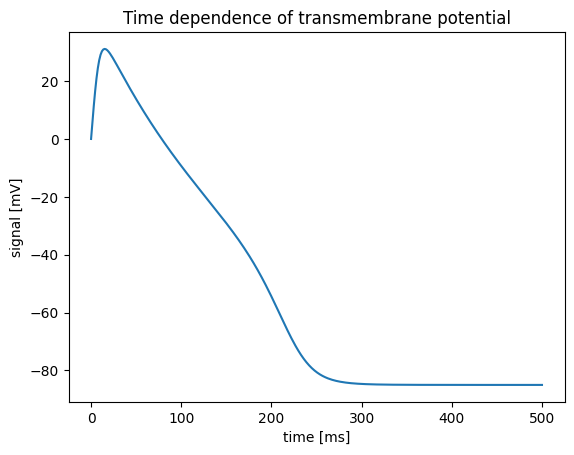

In [8]:
import matplotlib.pyplot as plt

time = np.linspace(0, T, len(signal))
plt.plot(time, signal)
plt.xlabel("time [ms]")
plt.ylabel("signal [mV]")
plt.title("Time dependence of transmembrane potential")

### Plotting a final plot of transmembrane potential

In [9]:
utils.plot_function(V_m_n, V1)

Widget(value='<iframe src="http://localhost:35575/index.html?ui=P_0x7f267449c190_0&reconnect=auto" class="pyvi…